# Anaplan 2.0 API requests

### PROPERTY OF LEET EPM PRIVATE LIMITED  
### Not for general distribution  
### Please contact anirudh@eliteepm.com  

## SECTION I: Authentication and OAuth 2.0 API  
[Official Documentation Link for Authentication](https://anaplanauthentication.docs.apiary.io/)  
[Official Documentation Link for OAuth 2.0](https://anaplanoauth2service.docs.apiary.io)

#### Expand this to view decision flow for Authentication Type

![Alt text](notebook_images/Anaplan_Authentication_Flow_2_50.png)

### 1. Basic Authentication

Store credentials in a text file. Credentials format should be username:password  
Use this for basic authentication

#### Load Credentials

In [ ]:
c = open("credentials.txt",'r',newline=None)
r = c.readlines()
fullCreds = r[0]
username = fullCreds[0:(fullCreds.find(':'))]
print("↓↓ Ready ↓↓")

#### Ready and validate credentials - Basic

In [ ]:
import base64
import requests
import json

# API v2.0 steps are:
# 1. encode b64 string of "Basic username:password"
# 2. pass 1. to auth.anaplan.com to get auth token
# 3. token is generated in json under tokenInfo -> tokenValue
# 4. Authorization header is ready; 'AnaplanAuthToken tokenValue'
# 5. Validate auth

cred_string = {'Authorization':'Basic ' + base64.b64encode((fullCreds).encode('utf-8')).decode('utf-8')}
print(cred_string)
print("↓↓ Passing to receive token ↓↓")

#Fetch token

fetchToken_url = 'https://auth.anaplan.com/token/authenticate'
request = requests.post(fetchToken_url, headers=cred_string)
fullTokenjson = json.loads(request.text)
write = request.text
auth = 'AnaplanAuthToken ' + fullTokenjson['tokenInfo']['tokenValue']
print(auth)
print("↓↓ Checking validity ↓↓")

#Check token validity

validate_url = 'https://auth.anaplan.com/token/validate'
header = {'Authorization' : auth}

request = requests.get(validate_url, headers = header)
status =json.loads(request.text)
print(status)
print(status['statusMessage'])

### 2. Certificate Authentication

#### Expand this to see how to get public and private pem files

1. Purchase valid SAML certificate from supported Certificate Authorities; official list from Anaplan  
https://help.anaplan.com/supported-root-ca-certificates-with-anaplan-4475afaf-4c2f-4728-b0e9-a1db858b79f6
2. Which certificate to buy?  

![Alt text](notebook_images/image.png)  

3. Procure p12 file from CA. The email in the certificate must also be added in the Anaplan workspace as a Non-SSO User. Also note down the password provided when procuring the cert  
4. Download and install OpenSSL from
https://slproweb.com/products/Win32OpenSSL.html
5. Create the public .pem file  
    * Run the following command including the double quotes to start the OpenSSL program:  
    "C:\Program Files\openssl-win64\bin\openssl.exe”  
    * Extract the .pem file from the digital certificate, to do this enter the following command (Note that the location of p12 certificate may be different)  
    * pkcs12 -in C:\certname.p12 -nokeys -out C:\Certificates\new_cert_name.pem
    * Enter the password for cert, new .pem file will be placed in the Certificates folder.
6. Create the private key .pem file
    * pkcs12 -in C:\cert_name.p12 -nocerts -out c:\Certificates\new_private_key.key nodes  
    * Enter the cert password  
    * Once complete a file with the extension .key will be created in the Certificates folder. Rename the extension to .pem

#### Ready and validate credentials - Certificate

After converting from p12 format to public pem and private pem;  
Private Key -> No changes to be made
Public Key -> Use the same one that is imported in Tenant Admin, in other words, remove all info outside the first BEGIN CERTIFICATE and END CERTIFICATE

In [ ]:
from base64 import b64encode
import os
import requests
from OpenSSL import crypto
import json

# Provide path to the file
certfile = "public.pem"
keyfile = "private.pem"

st_cert = open(certfile, 'rt').read()
cert = crypto.load_certificate(crypto.FILETYPE_PEM, st_cert)

st_key = open(keyfile, 'rt').read()
key = crypto.load_privatekey(crypto.FILETYPE_PEM, st_key)

pem = crypto.dump_certificate(crypto.FILETYPE_TEXT, cert)
random_str = os.urandom(100)
signed_str = crypto.sign(key, random_str, "sha512")

st_cert = (st_cert.replace("\n", "").replace(
    "-----BEGIN CERTIFICATE-----", "").replace("-----END CERTIFICATE-----", ""))

auth_headers = {'AUTHORIZATION': 'CACertificate ' + st_cert}

encodedstr = b64encode(random_str)
signedstr = b64encode(signed_str)

body = {'encodedData': encodedstr.decode("utf-8"),
        'encodedSignedData': signedstr.decode("utf-8")}

body = json.dumps(body)

anaplan_url = 'https://auth.anaplan.com/token/authenticate'
r = requests.post(url=anaplan_url, headers=auth_headers, data=body)

fullTokenjson = json.loads(r.text)
print(fullTokenjson)

auth = 'AnaplanAuthToken ' + fullTokenjson['tokenInfo']['tokenValue']
print(auth)
print("↓↓ Checking validity ↓↓")

#Check token validity

validate_url = 'https://auth.anaplan.com/token/validate'
header = {'Authorization' : auth}

request = requests.get(validate_url, headers = header)
status =json.loads(request.text)
print(status)
print(status['statusMessage'])

### 3. OAuth 2.0

#### 3.1 OAuth Authorization Code Flow

[Create an Authorization client following these steps](https://help.anaplan.com/create-an-oauth-20-client-0984a799-a667-4e70-8759-a134be32f48c)  
Input the blank fields below to construct the URL  
Then visit the link constructed in the output and authorize the application  
After successfull authorization, it will redirect to the specified redirect URI  
Copy the URI and keep it ready for the next step

In [ ]:
from oauthlib.oauth2 import WebApplicationClient

authorization_url = 'https://us1a.app.anaplan.com/auth/authorize'

client_id = ''
client_secret = ''
redirect_uri = ''
client = WebApplicationClient(client_id)

url = client.prepare_request_uri(
  authorization_url,
  redirect_uri = redirect_uri,
  scope = 'openid profile email offline_access'
)
print(url)

In [ ]:
## Paste the redirected URI into this variable
redirected_uri = ''

import requests
import json

from urllib.parse import urlparse, parse_qs

parsed = urlparse(redirected_uri)
code = parse_qs(parsed.query)['code'][0]

token_url = 'https://us1a.app.anaplan.com/oauth/token'
header = {'Content-Type' : 'application/json'}

body = {
    'grant_type' : 'authorization_code',
    'client_id' : client_id,
    'code' : code,
    'client_secret' : client_secret,
    'redirect_uri' : redirect_uri

}

request = requests.post(token_url, headers = header, json=body)
fullToken = json.loads(request.text)
auth = 'AnaplanAuthToken ' + fullToken['access_token']
print(auth)

#### 3.2 OAuth Device Code Flow

[Create a Device client following these steps](https://help.anaplan.com/create-an-oauth-20-client-0984a799-a667-4e70-8759-a134be32f48c)  
Input the client id and receive the URL  
Then visit the link constructed in the output and authorize the application  
That's it! Run the next piece of code to get the authorization token

In [ ]:
import requests
import json

client_id = ''

token_url = 'https://us1a.app.anaplan.com/oauth/device/code'
header = {'Content-Type' : 'application/json'}

body = {
    'client_id' : client_id,
    'scope' : 'openid profile email offline_access'
}

request = requests.post(token_url, headers=header, json=body)
fullToken = json.loads(request.text)

print(f"Go to this URL and authorize. Then enter this code: {fullToken['user_code']}")
print(fullToken['verification_uri'])

In [ ]:
token_url = 'https://us1a.app.anaplan.com/oauth/token'
header = {'Content-Type' : 'application/json'}

body = {
    'grant_type' : 'urn:ietf:params:oauth:grant-type:device_code',
    'client_id' : client_id,
    'device_code' : fullToken['device_code']
}

request = requests.post(token_url, headers = header, json=body)
j = json.loads(request.text)

auth = 'AnaplanAuthToken ' + j['access_token']
print(auth)

### 4. Refresh Token

Tokens expire every 35 minutes. Refresh using this function. The argument expected by the function is 'AnaplanAuthToken ' followed by a valid unexpired token in the same format

In [ ]:
def refreshToken(authToRefresh):
    
    refresh_url = 'https://auth.anaplan.com/token/refresh'
    header = {'Authorization' : authToRefresh}
    
    request = requests.post(refresh_url, headers = header)
    fullTokenjson = json.loads(request.text)
    return 'AnaplanAuthToken ' + fullTokenjson['tokenInfo']['tokenValue']

auth = refreshToken(auth)
print(auth)

## SECTION II-A: Transactional APIs - Model Level  
Get Workspaces, Models, Line Items

### 1. Get Workspaces  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/workspaces)

#### 1.1 Get all WS Info

Get the list of workspaces that user has access to. Note the optional query parameter of tenantDetails. If not included the currentSize is excluded in the json output

In [ ]:
workspaces_url = 'https://api.anaplan.com/2/0/workspaces?tenantDetails=true'
header = {'Authorization' : auth}

request = requests.get(workspaces_url, headers = header)
ws = json.loads(request.text)

print(ws['workspaces'])

#### 1.2 Get Specific WS Info

Same query as the one above; except it returns the json object of only one WS that's specified. Note that the query parameter is optional

In [ ]:
ws_id = ''
workspaces_url = f'https://api.anaplan.com/2/0/workspaces/{ws_id}?tenantDetails=true'
header = {'Authorization' : auth}

request = requests.get(workspaces_url, headers = header)
ws = json.loads(request.text)

print(ws['workspace'])

### 2. Get Models  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/models)

#### 2.1 Get all Models Info

Get the list of models that user has access to (including Archived models). Note the optional parameter which will include current memory usage and other model metadata

In [ ]:
models_url = 'https://api.anaplan.com/2/0/models?modelDetails=true'
header = {'Authorization' : auth}

request = requests.get(models_url, headers = header)
models = json.loads(request.text)

print(models['models'])

#### 2.2 Get specific Model Info

Get specific model info, requires specifying the model ID. Note the optional parameter which will include current memory usage and other model metadata

In [ ]:
model_id = ''
models_url = f'https://api.anaplan.com/2/0/models/{model_id}?modelDetails=true'
header = {'Authorization' : auth}

request = requests.get(models_url, headers = header)
models = json.loads(request.text)

print(models['model'])

#### 2.3 Check Model Status

Check what the model is doing right now, including model lock status or processing user request etc.  
__Note__: The documentation says this is a POST request, but it only accepts GET

In [ ]:
ws_id = ''
model_id = ''
models_url = f'https://api.anaplan.com/2/0/workspaces/{ws_id}/models/{model_id}/status'
header = {'Authorization' : auth,
          'Content-Type' : 'application/json',
         'Accept' : 'application/json'}

request = requests.get(models_url, headers = header)
models = json.loads(request.text)

print(models)

#### 2.4 Delete Models

Send an array of models to be deleted from a workspace. Model must be in closed status first

In [ ]:
ws_id = ''
models = ['model_id_1_here', 'model_id_2_here']
body = {"modelIdsToDelete": models}
models_url = f'https://api.anaplan.com/2/0/workspaces/{ws_id}/bulkDeleteModels'
header = {'Authorization' : auth}

request = requests.post(models_url, headers = header, json=body)
models = json.loads(request.text)

print(models)

### 3. *Set workspace and model*

Variables to control which workspace and model is being accessed. Cannot proceed with any of the requests below unless WS ID and Model ID are set here

In [ ]:
accessWS = ''
accessM = ''

### 4. Get Line Items  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/line-items)

#### 4.1 Retrieve all Line Items in a model

Get all the line items and their IDs in the model. This is much more useful with the query parameter includeAll=true; demonstrated in another call

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/lineItems/'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)

print(lis['items'])

#### 4.2 Retrieve Dimension IDs for one line item

Give the ID of one LI and retrieve all dimension IDs against that LI

In [ ]:
li_id = ''

tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/lineItems/{li_id}/dimensions'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)

print(lis['dimensions'])


#### 4.3 Retrieve every line item metadata in one model

Same request as 4.1 but much more granular

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/lineItems?includeAll=True'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)

print(lis['items'])

#### 4.4 Retrieve every line item metadata in one module  

Same request again as 4.1 but much more granular and limited to one particular module  
Special Notes from docs  

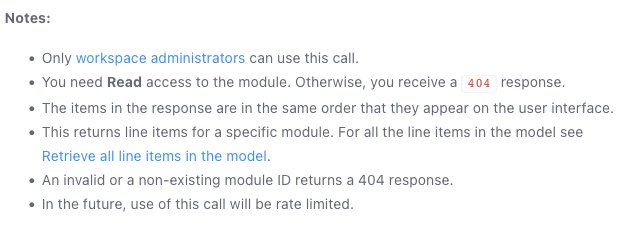

In [ ]:
module_id = ''
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/modules/{module_id}/lineItems?includeAll=True'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)

print(lis['items'])

### 5. Other Model Metadata  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#OtherModelMetadata)

####  5.1 Retrieve Item IDs for dimension in line item

Point to a particular line item and it's applied dimension and receive every member of that dimension  
Special Notes  
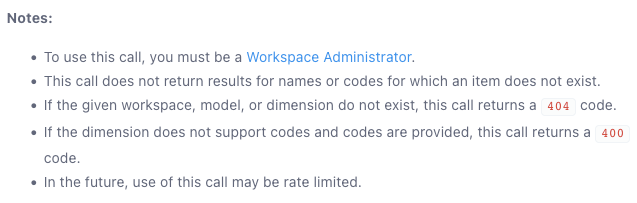

In [ ]:
li_id = ''
dim_id = ''
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/lineItems/{li_id}/dimensions/{dim_id}/items'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)
print(lis['items'])

####  5.2 Retrieve Item IDs for any one dimension

Point to a particular dimension and receive every member of that dimension  
Special Notes  
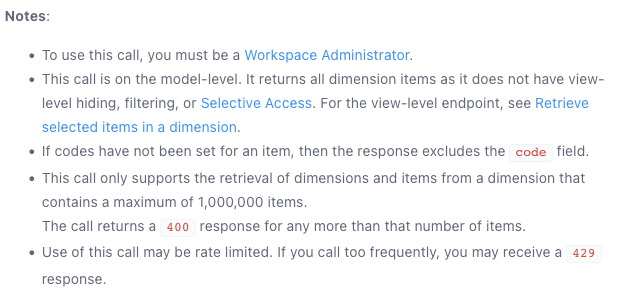

In [ ]:
dim_id = ''
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/dimensions/{dim_id}/items'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)
print(lis['items'])

####  5.3 Retrieve Item IDs for any one dimension and any one module/saved view/line item

Point to a particular dimension and particular module or its saved view and receive every member of that dimension  
Special Notes  
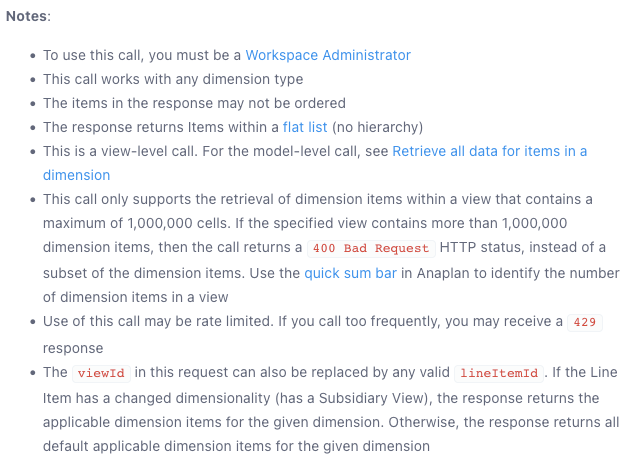

In [ ]:
dim_id = ''
view_id = ''
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/views/{view_id}/dimensions/{dim_id}/items'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)
print(lis['items'])

## SECTION II-B: Transactional APIs - Module level  
Get Modules, Views, Read Cell Data, Create Large Volume requests and Update Cell Data

### 6. Read Module, view Metadata and limited volume cell data  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#ModuleAndViewData)

#### 6.1 Retrieve Module IDs across model

Get all the module IDs for further API calls

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/modules'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
modules = json.loads(request.text)
print(modules['modules'])

#### 6.2 Retrieve View IDs across model

Get all the view IDs for further API calls. Note the query parameter which is optional  
Special Notes  
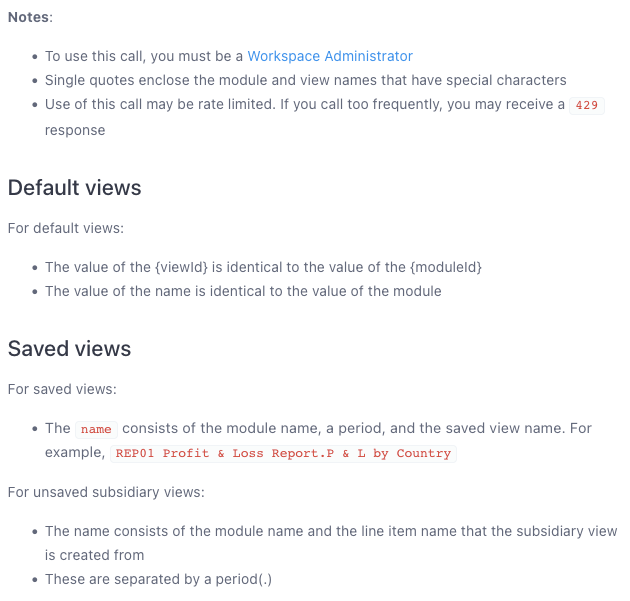

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/views?includeSubsidiaryViews=True'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
modules = json.loads(request.text)
print(modules['views'])

#### 6.3 Retrieve a given Module's Line Items

Same request as Line Item requests from above section but restricted to a specific module

In [ ]:
module_id = ''

tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/modules/{module_id}/lineItems'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lis = json.loads(request.text)
print(lis['items'])

#### 6.4 Retrieve a given Module's Views

Same request as above but restricted to a specific module

In [ ]:
module_id = ''

# include subsidiary view parameter may be removed or set to false
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/modules/{module_id}/views?includesubsidiaryviews=True'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
views = json.loads(request.text)
print(views['views'])

#### 6.5 Retrieve View metata in a module view

Helps understand how dimensions are spread across the view  
Added special parsing to make it human readable

In [ ]:
view_id = ''

# include subsidiary view parameter may be removed or set to false
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/views/{view_id}'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
view_md = json.loads(request.text)
print(view_md)

print('Special Parsing\nColumns:')
try:
    view_md['columns']
    for member in view_md['columns']:
        print(member,'\n')
except:
    print('No column axis on this view','\n')

print('Rows:')
try:
    view_md['rows']
    for member in view_md['rows']:
        print(member,'\n')
except:
    print('No row axis on this view','\n')

print('Page Selector:')
try:
    view_md['pages']
    for member in view_md['pages']:
        print(member,'\n')
except:
    print('No page axis on this view','\n')

#### 6.6 Download data from Module View

Lots of special notes and restrictions on this API call. Worth reading the [official docs](https://anaplanbulkapi20.docs.apiary.io/#RetrieveCellDataView) in full

In [ ]:
view_id = ''

# Call for a view with No page selectors
print('Regular CSV Call\n')
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/views/{view_id}/data'

header = {'Authorization' : auth,
         'Accept' : 'text/csv'}

request = requests.get(tran_url, headers = header)
data = request.text
print(data)
    
# Call for a view with Page selector
# format for the pages argument is dimension id: member id
# Replace the zeroes with your dimension id and member id
print('\n Page Selector Call \n')
dim_id = 0
dim_item_id = 0

tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/views/{view_id}/data?pages={dim_id}:{dim_item_id}'

header = {'Authorization' : auth,
         'Accept' : 'text/csv'}

request = requests.get(tran_url, headers = header)
data_ps = request.text
print(data_ps)

# Call for JSON view
print('Regular Json Call\n')
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/views/{view_id}/data?format=v1'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
data = request.text
print(data)

### 7. Large Volume requests  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#ReadLargeVolumeListItemData)

#### Initiate request

Must be a WSA. Probably because views need to be created on the module itself

Options available for export types are:  
GRID_ALL_PAGES  
TABULAR_SINGLE_COLUMN  
TABULAR_MULTI_COLUMN

In [ ]:
module_id = ''

tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/views/{module_id}/readRequests/'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

body = {
      "exportType": "TABULAR_MULTI_COLUMN"
    }

request = requests.post(tran_url, headers = header, json = body)
f = json.loads(request.text)
print(f)
req_id = f['viewReadRequest']['requestId']
print(req_id)

#### Check the status of the request and view number of available pages

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/views/{module_id}/readRequests/{req_id}'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
f = json.loads(request.text)
print('Number of pages: ')
print(f['viewReadRequest']['availablePages'])
print(f['viewReadRequest']['requestState'])

#### Finally download the data. Loop this code for each available page and then concatenate the data

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/views/{module_id}/readRequests/{req_id}/pages/0'

header = {'Authorization' : auth,
         'Accept' : 'text/csv'}

request = requests.get(tran_url, headers = header)
print(request.text)

#### Delete read requests

As per Anaplan:  

As a best practice, use this call to clear all pages from completed exports as soon as you download all pages. Doing so will make space available for future exports.  
The system will automatically reclaim space for read requests not accessed for over 30 minutes. The same applies to failed read requests.

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/views/{module_id}/readRequests/{req_id}'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.delete(tran_url, headers = header)
f = json.loads(request.text)
print(request.text)

### 8. Update cell data  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/update-module-cell-data)

Notes  
* Rate Limit - 1000 cells per request only
* Item ID is interchangeable with item name, item code
* Dimension ID is interchangeable with dimension name
* Line Item ID is interchangeable with Line Item name
* value cannot be null

Worth reading the [full docs](https://anaplanbulkapi20.docs.apiary.io/#/reference/update-module-cell-data)

In [ ]:
module_id = ''
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/modules/{module_id}/data'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

# In the empty quotes below input the IDs of LI, Dimension and respective Item of that dimension

body = [
    {
      "lineItemId": "",
      "dimensions": [
          { "dimensionId": "", "itemId": "" }
      ],
      "value": 1111
    }
]

request = requests.post(tran_url, headers = header, json = body)
f = json.loads(request.text)
print(f)

# Example with names instead of IDs
# In the empty quotes below input the names of LI, Dimension and respective Item of that dimension

body = [
    {
      "lineItemName": "",
      "dimensions": [
          { "dimensionName": "", "itemName": "" }
      ],
      "value": 2222
    }
]

request = requests.post(tran_url, headers = header, json = body)
f = json.loads(request.text)
print(f)


Example of updating cell data with no dimensions

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/modules/{module_id}/data'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

body = [
    {
      "lineItemId": "",
      "dimensions": [
      ],
      "value": True
    }
]

request = requests.post(tran_url, headers = header, json = body)
f = json.loads(request.text)
print(f)

## SECTION II-C: Transactional APIs - List level
Get Lists, Modify Lists

### 9. Get Lists and List Data  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/model-lists)

#### 9.1 Retrieve List IDs

Fetch all lists for further API calls

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lists = json.loads(request.text)
print(lists['lists'])

#### 9.2 Retrieve List Metadata

Get Metadata against list similar to receiving metadata against line items

In [ ]:
list_id = ''
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
lists_md = json.loads(request.text)
print(lists_md['metadata'])

#### 9.3 Retrieve List Items

In [ ]:
list_id = ''

# include all parameter may be removed or set to false
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/items?includeAll=True'


# JSON request
header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
list_data = json.loads(request.text)
print(list_data)
    
# CSV request
header = {'Authorization' : auth,
         'Accept' : 'text/csv'}

request = requests.get(tran_url, headers = header)
print(request.text)

#### 9.4 Add member to List

Only 100K members can be added in a single request  
Numbered list will not accept name property  
Both this request and 9.5 have a lot of nuance, visit official docs to learn more

In [ ]:
list_id = ''
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/items?action=add'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

body = {
  "items": [
    {
      "name": "Country X",
      "code": "",
      "parent": "AMER",
      "properties": {
        "pCurrency":"USD"
      },
    "subsets": {
    }
  }
  ]
}

request = requests.post(tran_url, headers = header, json = body)
f = json.loads(request.text)
print(f)

#### 9.5 Update member of List

Refer official docs for full details

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/items'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

body = {
  "items": [
    {
      "name": "Country X",
      "code": "",
      "parent": "APAC",
      "properties": {
        "pCurrency":"SGD"
      },
    "subsets": {
    }
  }
  ]
}

request = requests.put(tran_url, headers = header, json = body)
f = json.loads(request.text)
print(f)

#### 9.6 Delete member of List

Delete a particular member from the list permanently. Rate limited to 100K per request
Code of the list may be submitted or the ID of the dimension member may be submitted as an "id" argument in the json

In [ ]:
list_id = ''
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/items?action=delete'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

body = {
  "items": [
    {
      "code": "SITE_190"
  }
  ]
}

request = requests.post(tran_url, headers = header, json = body)
f = json.loads(request.text)
print(f)

### 10. Large Volume List Request  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/read-large-volume-list-item-data)

#### Preview request

Preview the list data before downloading. Loads only 1000 rows. Must be a WSA

In [ ]:
list_id = ''

tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/preview'

header = {'Authorization' : auth,
         'Accept' : 'text/csv'}

request = requests.get(tran_url, headers = header)
print(request.text)

#### Initiate request

Initiate the request to read the large list

In [ ]:
list_id = ''

tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/readRequests'

header = {'Authorization' : auth,
         'Content-Type' : 'application/json'}

request = requests.post(tran_url, headers = header)
j = json.loads(request.text)
req_id = j['listReadRequest']['requestId']
print(j)
print(j['listReadRequest']['requestState'])
print(req_id)

#### Check request status

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/readRequests/{req_id}'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
f = json.loads(request.text)
print('Number of pages: ')
print(f['listReadRequest']['availablePages'])
print(f['listReadRequest']['requestState'])

#### Finally download the data. Loop this code for each available page and then concatenate the data

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/readRequests/{req_id}/pages/0'

header = {'Authorization' : auth,
         'Accept' : 'text/csv'}

request = requests.get(tran_url, headers = header)
print(request.text)

#### Delete read requests

As per Anaplan:  

As a best practice, use this call to clear all pages from completed exports as soon as you download all pages. Doing so will make space available for future exports.  
The system will automatically reclaim space for read requests not accessed for over 30 minutes. The same applies to failed read requests.

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/lists/{list_id}/readRequests/{req_id}'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.delete(tran_url, headers = header)
f = json.loads(request.text)
print(request.text)

## SECTION II-D: Transactional APIs - Calendar/Versions/Users  
Change Calendar settings, Change Version Settings, view user metadata etc

### 11. Model Calendar APIs  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/model-calendar)

#### 11.1 Retrieve Current Period

Get the current period setting from the Time setting in the model

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/currentPeriod'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
cp = json.loads(request.text)
print(cp)

print(cp['currentPeriod']['periodText'])


#### 11.2 Change Current Period

Change the current period. Use the query parameter suffix. The format must be YYYY-MM-DD  
Potentially destructive action. Execute with care

In [ ]:
# input date variable here
date = '2022-02-07'
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/currentPeriod?date={date}'

header = {'Authorization' : auth,
          'Accept' : 'application/json',
         'Content-Type' : 'application/json'}

request = requests.put(tran_url, headers = header)
print(request.text)

#### 11.3 Retrieve Current FY

Get the current Financial year setting in the model calendar

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/modelCalendar'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
mc = json.loads(request.text)
print(mc)

print(mc['modelCalendar']['fiscalYear'])


#### 11.4 Change Current FY

Potentially destructive action. Execute with caution

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/modelCalendar/fiscalYear'

header = {'Authorization' : auth,
          'Accept' : 'application/json',
         'Content-Type' : 'application/json'}

# Input the year here
body = {'year' : 'FY23'}

request = requests.put(tran_url, headers = header, json = body)
print(request.text)

### 12. Version APIs  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/model-versions)

#### 12.1 Retrieve Version Metdata

Get current Anaplan versions and respective settings

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/versions/'

header = {'Authorization' : auth,
         'Accept' : 'application/json'}

request = requests.get(tran_url, headers = header)
vs = json.loads(request.text)

print(vs['versionMetadata'])

version_id = vs['versionMetadata'][1]['id']
print(version_id)

#### 12.2 Change Switchover Period

Change the switchover period for a given version. Version ID can be extracted from the above request  
Potentially destructive action. Execute with caution

In [ ]:
tran_url = f'https://api.anaplan.com/2/0/models/{accessM}/versions/{version_id}/switchover'

header = {'Authorization' : auth,
         'Content-Type' : 'application/json'}

body = {'date' : '2023-02-13'}

request = requests.put(tran_url, headers = header, json = body)
print(request.text)

### 13. User APIs  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#/reference/users)

#### 13.1 Retrieve All users in tenant

Get all user details in the tenant

In [ ]:
user_url = 'https://api.anaplan.com/2/0/users/'
header = {'Authorization' : auth}

request = requests.get(user_url, headers = header)
user = json.loads(request.text)

print(user)

#### 13.2 Retrieve Your user in the tenant

Get your user details

In [ ]:
user_url = 'https://api.anaplan.com/2/0/users/me'
header = {'Authorization' : auth}

request = requests.get(user_url, headers = header)
user = json.loads(request.text)

print(user)

#### 13.2 Retrieve a specific user

Get a specific user details through ID

In [ ]:
user_id = '8a81b01271f9028d01720424fb9a5bc6'
user_url = f'https://api.anaplan.com/2/0/users/{user_id}'
header = {'Authorization' : auth}

request = requests.get(user_url, headers = header)
user = json.loads(request.text)

print(user)

## SECTION III: All Bulk APIs  
Imports/Exports/Actions/Processes and their metadata. Run any task in Anaplan

Variables to control which workspace and model is being accessed. Cannot proceed with any of the requests below unless WS ID and Model ID are set here

In [ ]:
accessWS = ''
accessM = ''
print('Set!')

### 1. Flat file upload  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#Upload-files)

Chunking always done before file upload. Specify chunk in MB with chunk_size. Anaplan maximum is 50MB per chunk  
Note neither the begin request nor the complete request are entirely necessary.  

Put request returns a No Content 204 response  
The other two requests return 200

In [ ]:
import pathlib

fileName = ''
file_size = pathlib.Path(fileName).stat().st_size

fileID = ''
chunk_size = 10 #Set this in megabytes
megabyte = 1048576

uploadFile_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/files/{fileID}'

startHeader = {'Authorization' : auth,
              'Content-Type' : 'application/json'}

putHeader = {'Authorization' : auth,
          'Content-Type' : 'application/octet-stream'}


# If you know the exact chunkCount then put that in place of -1 else leave as is
bodyBegin = {'id' : fileID,
            'chunkCount' : -1}

bodyComplete = {'id' : fileID,
               'chunkCount' : file_size/(megabyte * chunk_size)}

# Inform server that upload is beginning
beginUpload_request = requests.post(url = uploadFile_url, headers = startHeader, json = bodyBegin)

# request.ok confirms that file id is acceptable
if beginUpload_request.ok:
    print('Beginning upload...')
    chunkNum = 0
    with open(fileName, 'rt') as f:
        
        # readlines with argument to read initial section for the loop
        chunkedData = f.readlines(chunk_size * megabyte)
        
        # this while loop returns false when readlines runs out of bytes to read
        while chunkedData:
            upload_data = ''
            
            for line in chunkedData:
                upload_data += line
            
            # upload chunk with byte specified by chunk_size
            putUpload_request = requests.put(uploadFile_url + '/chunks/' + str(chunkNum),
                                            headers = putHeader, data = upload_data)
            # 204 expected
            print(f'Uploading {chunkNum}. Reported status code: {putUpload_request.status_code}')
            chunkedData = f.readlines(chunk_size * megabyte)
            chunkNum += 1
            
    # Mark upload as complete
    completeUpload_request = requests.post(url = uploadFile_url + '/complete', headers = startHeader, json = bodyComplete)
    print(completeUpload_request.text)
else:
    print('Unable to upload, please check fileID and metadata')

### 2. Import Actions - 112  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#Import)

#### 2.1 Get All Import Actions

Get the list of imports in the model. Saved locally as imports.json

In [ ]:
imports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/imports'
header = {'Authorization' : auth}

request = requests.get(imports_url, headers = header)
imports = json.loads(request.text)

print(imports['imports'])

#### 2.2 Get import action metadata

Get info of mappings in the import action. Very useful to get file mappings in json array

In [ ]:
import_id = ''
imports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/imports/{import_id}/'
header = {'Authorization' : auth}

request = requests.get(imports_url, headers = header)
imports = request.text

print(imports)

### 3. Export Actions - 113/116  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#Export)

#### 3.1 Get Exports/Files

Get the list of exports in the model. Replace the word exports with files to get both Upload files (113) and Export files (116)

In [ ]:
exports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/files'
# exports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/exports'
header = {'Authorization' : auth}

request = requests.get(exports_url, headers = header)
exports = json.loads(request.text)

print(exports)

#### 3.2 Get Exports Action metadata

Get metadata of the data being exported from the file. To download the file go to Download Files Section

In [ ]:
export_id = ''
exports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/exports/{export_id}'
header = {'Authorization' : auth}

request = requests.get(exports_url, headers = header)
exports = json.loads(request.text)

print(exports)

### 4. Model Actions - 117  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#Actions)

#### 4.1 Get Actions

Get the list of actions in the model. Very comprehensive notes in the official docs

In [ ]:
actions_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/actions'
header = {'Authorization' : auth}

request = requests.get(actions_url, headers = header)
actions = json.loads(request.text)
print(actions)

#### 4.2 Get Action metadata

Get metadata of the specified action

In [ ]:
action_id = ''
exports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/actions/{action_id}'
header = {'Authorization' : auth}

request = requests.get(exports_url, headers = header)
actions = json.loads(request.text)

print(actions)

### 5. Model Processes - 118  
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#Process)

#### 5.1 Get Processes

Get the list of processes in the model

In [ ]:
processes_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/processes'
header = {'Authorization' : auth}

request = requests.get(processes_url, headers = header)
processes = json.loads(request.text)

print(processes['processes'])

#### 5.2 Get Process Metadata

Get metadata against any given process

In [ ]:
process_id = ''
processes_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/processes/{process_id}'
header = {'Authorization' : auth}

request = requests.get(processes_url, headers = header)
processes = json.loads(request.text)

print(processes['processMetadata'])

### 6. Run/Monitor/Download Failure Logs
Common code for Imports/Exports/Actions/Processes

#### 6.1 Run Import/Export/Action/Process

Run an import, export or an action; define the ID  
Auto check if provided ID is an export, import or task  
Expected response: 200

In [ ]:
# Input any 112, 116, 118 or 117 ID here and code will run that action
# Run, Monitor, check failure log is same code for all 4 types of tasks

action_id = ''

if action_id[:3] == '112':
    actions = 'imports'
elif action_id[:3] == '116':
    actions = 'exports'
elif action_id[:3] == '118':
    actions = 'processes'
else:
    actions = 'actions'
runAction_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/{actions}/{action_id}/tasks'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'}

body = {'localeName' : 'en_US'}

request = requests.post(runAction_url, headers = header, json = body)
print(request.text)

f = json.loads(request.text)
task_id = f["task"]["taskId"]
print(task_id)

#### 6.2 Get a list of all tasks against the provided action

Whenever any action is triggered on Anaplan it returns a Task ID for further monitoring. Run this to view all Task IDs against the action. Task IDs are stored in the model for 48 hours

In [ ]:
imports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/{actions}/{action_id}/tasks'
header = {'Authorization' : auth}

request = requests.get(imports_url, headers = header)
req = json.loads(request.text)

print(req['tasks'])

#### 6.3 Monitor Given Task

Monitor the live status of a given task. Failure dump ID will also be available if there are any failure logs to review. If using this call for a process, the failure log is returned for each action in that process as well as for the process itself. Note the json object carefully. To download the failure log from an action within a process, note down the object ID 

In [ ]:
imports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/{actions}/{action_id}/tasks/{task_id}'
header = {'Authorization' : auth}

request = requests.get(imports_url, headers = header)
req = json.loads(request.text)

print(req['task'])
print(f'Failure dump available is: ' + str(req['task']['result']['failureDumpAvailable']))

#### 6.4 Download failure dump

Download the csv dump that Anaplan also presents in the front end if this action fails. Specify object ID if this failure log required for a specific action within the process. If failure log on whole process is required, use the first URL. if failure log on only one action within a process is required, use the second URL

In [ ]:
imports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/{actions}/{action_id}/tasks/{task_id}/dump'
# imports_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/{actions}/{action_id}/tasks/{task_id}/dumps/{object_id}'
header = {'Authorization' : auth}

request = requests.get(imports_url, headers = header)
req = request.text

print(req)

### 7. Download Files - 113/116
[Official Documentation Link](https://anaplanbulkapi20.docs.apiary.io/#Download-files)

#### 7.1 Download Export file; chunk count

To get the list of available files in the model check the Export Actions section. This can apply to either an export ID or an uploaded file  
This call only returns the number of chunks in the export file

In [ ]:
export_id = ''
exportChunk_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/files/{export_id}/chunks'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
          }

# Get Chunk IDs
chunkRequest = requests.get(exportChunk_url, headers = header)
print(request.text)

#### 7.2 Download Export file; file

Each chunk must be downloaded and combined manually  
Note this code just dumps as txt file. Change per export

In [ ]:
download_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/files/{export_id}/chunks/'

header = {'Authorization' : auth,
           'Content-Type': 'application/octet-stream'
          }

download_export = ''
for download_chunk in chunkRequest['chunks']:
    chunk_id = download_chunk['id']
    print(f'Downloading chunk ID: {chunk_id}')
    request = requests.get(f'{download_url}/{chunk_id}', headers = header)
    download_export += request.text

print(request.text)

#### 7.3 Delete Upload file

Delete Files uploaded via API. Applies to 113 only. Returns 204 code only. Nothing else in the request text

In [ ]:
delete_url = f'https://api.anaplan.com/2/0/workspaces/{accessWS}/models/{accessM}/files/{export_id}'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
          }

request = requests.delete(delete_url, headers = header)
print(request)

## SECTION IV: ALM APIs  
All actions wrt Application Lifecycle management in Anaplan  
[Official Documentation Link for ALM](https://almapi.docs.apiary.io/)  

Variables to control which workspace and model is being accessed. Cannot proceed with any of the requests below unless WS ID and Model ID are set here

In [ ]:
dev_ws = ''
dev_model = ''

prod_ws = ''
prod_model = ''
print('Set!')

### 1. Change Model's Online/Offline Status

Use this to coordinate downtime on a production model

In [ ]:
alm_status_url = f'https://api.anaplan.com/2/0/models/{prod_model}/onlineStatus'
header = {'Authorization' : auth,
         'Content-Type' : 'application/json'
         }
# Uncomment the status you want to apply
body = {'status' : 'online'}
# body = {'status' : 'offline'}

request = requests.put(alm_status_url, headers = header, json = body)
print(request)

### 2. Fetch Source Model RT IDs

Fetch all RTs compatible with the production model structure from a given dev model

In [ ]:
# Note: deployed model ID needs to be provided
alm_sync_url = f'https://api.anaplan.com/2/0/models/{prod_model}/alm/syncableRevisions?sourceModelId={dev_model}'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
         }

request = requests.get(alm_sync_url, headers = header)
print(request.text)
f = json.loads(request.text)

try:
    source_id = f['revisions'][0]['id']
except:
    source_id = ""
    print('No Valid RT found in selected source model')

print(source_id)

### 3. Fetch Latest Model RT ID

Fetch only the latest RT from the production model

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{prod_model}/alm/latestRevision'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
         }

request = requests.get(alm_sync_url, headers = header)

print(request.text)
f = json.loads(request.text)
target_id = f['revisions'][0]['id']
print(target_id)

### 4. Sync from Source to Target

Perform the sync and review errors if any

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{prod_model}/alm/syncTasks'
header = {'Authorization' : auth,
         'Content-Type' : 'application/json'
         }

body = {
      "sourceRevisionId": f"{source_id}",
      "sourceModelId": f"{dev_model}",
      "targetRevisionId": f"{target_id}"
        }


request = requests.post(alm_sync_url, headers = header, json = body)
print(request.text)

f = json.loads(request.text)

try:
    f['status']['code'] = 201
    task_id = f['task']['taskId']
except:
    task_id = ""
    print('Sync not performed')

print(task_id)

### 6. Track Sync Task Progress

Specify a particular task and view its current status

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{prod_model}/alm/syncTasks/{task_id}'

header = {'Authorization' : auth
         }

request = requests.get(alm_sync_url, headers = header, json = body)
print(request.text)
f = json.loads(request.text)

sync_bool = f['task']['result']['successful']

if sync_bool == True:
    print('Successfully synced')
else:
    print('Encountered error in sync:\n')
    print({f['task']['result']['error']['messageText']})
    print({f['task']['result']['error']['messageText']})

### 7. Track all sync tasks

Run to fetch all sync tasks in the last 48 hours

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{prod_model}/alm/syncTasks'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
         }

request = requests.get(alm_sync_url, headers = header)
f = json.loads(request.text)
print(f['tasks'])

### 8. Create a Revision Tag

Create a revision tag in the dev model with name and description

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{dev_model}/alm/revisions'
header = {'Authorization' : auth,
         'Content-Type' : 'application/json'
         }

# Fill in the details of the name of RT and its description here
body = {
  "name": "RT from API",
  "description": "Test"
        }

request = requests.post(alm_sync_url, headers = header, json = body)
print(request.text)

f = json.loads(request.text)


### 9. Get all Revisions

Get all the revision tags in the dev model

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{dev_model}/alm/revisions'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
         }

request = requests.get(alm_sync_url, headers = header)
f = json.loads(request.text)
print(f['revisions'])

### 10. View which Revision was applied to which models

Run this to see if a given RT was applied to a model. Note the appliedMethod in json object for special details. This call returns both the dev model and the prod model details along with timestamps of the sync

In [ ]:
rt_id = ''
alm_sync_url = f'https://api.anaplan.com/2/0/models/{dev_model}/alm/revisions/{rt_id}/appliedToModels'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
         }

request = requests.get(alm_sync_url, headers = header)
f = json.loads(request.text)
print(f['appliedToModels'])

### 11. Create Summary/Full Comparison Report

Create a task to compare RTs and receive either a full or summary report. The word 'compare' will generate the full list of differences. Summary will only provide the summary. In both cases the result is same as Anaplan's front end result

In [ ]:
# Uncomment the type of comparison you want. The next 3 requests will follow this type

# compare_type = 'comparison'
compare_type = 'summary'

source_id = ''
target_id = ''

alm_sync_url = f'https://api.anaplan.com/2/0/models/{dev_model}/alm/{compare_type}ReportTasks'
header = {'Authorization' : auth,
         'Content-Type' : 'application/json'
         }

body = {
      "sourceRevisionId": f"{source_id}",
      "sourceModelId": f"{dev_model}",
      "targetRevisionId": f"{target_id}"
        }

request = requests.post(alm_sync_url, headers = header, json = body)
print(request.text)

f = json.loads(request.text)
task_id = f['task']['taskId']

print(task_id)

### 12. Check status of the generated report with given Task ID

Specify a particular task and view its current status

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{dev_model}/alm/{compare_type}ReportTasks/{task_id}'

header = {'Authorization' : auth
         }

request = requests.get(alm_sync_url, headers = header, json = body)
print(request.text)
f = json.loads(request.text)

sync_bool = f['task']['result']['successful']

if sync_bool == True:
    print('Successfully generated')
else:
    print('Encountered error:\n')
    print({f['task']['result']['error']['messageText']})
    print({f['task']['result']['error']['messageText']})

### 13. View the generated comparison report

Identical to Anaplan front end

In [ ]:
alm_sync_url = f'https://api.anaplan.com/2/0/models/{dev_model}/alm/{compare_type}Reports/{target_id}/{source_id}'

header = {'Authorization' : auth,
          'Content-Type' : 'application/json'
         }

request = requests.get(alm_sync_url, headers = header)
print(request.text)